## Visualizing the Bexar Data

To better understand potential features for future models, I visualized several of the variables. I started by plotting the criminally-linked properties on a map to determine if there was any geographic affiliation. I then visualized the differences between types of ownership. Next, I compared price per square foot across ownership types, foreign ownership, and owners who own multiple properties, among other variables. I then compared YoY price fluctuations between criminally-linked properties and the broader population of data. Lastly, I dropped several variables and plotted correlation.

In [22]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import json

sns.set_style('darkgrid')

import folium
from folium.plugins import HeatMap
from folium import plugins
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [2]:
# Load in data
prop_df = pd.read_hdf('../data/processed/bexar_processed.h5')

### Plot Properties on Map

In [4]:
# Pull out addresses and zip codes for criminally-linked properties
mapping_crim_df = prop_df[prop_df['crim_address'].notna()==True][['crim_address','property_zip']].reset_index()

In [5]:
print(mapping_crim_df.iloc[0,1])
address_to_try = mapping_crim_df.iloc[0,1]

25319 BOERNE STAGE RD SAN ANTONIO, TX 78255


In [23]:
# locator = geocoders.Nominatim(user_agent="property_mapping_project")
# geocode = RateLimiter(locator.geocode, min_delay_seconds=3)

# # location = geocode(address_to_try, exactly_one=True)
# print(location.latitude)

29.671213709513797


In [14]:
print(mapping_crim_df.head(10))
print(mapping_crim_df.shape)

   index                                 crim_address property_zip
0  82774  25319 BOERNE STAGE RD SAN ANTONIO, TX 78255        78255
1  87260        24424 BLANCO RD SAN ANTONIO, TX 78260        78260
2  94234      2227 SAWGRASS RDG SAN ANTONIO, TX 78260        78260
3  94265        2243 WINDING VW SAN ANTONIO, TX 78260        78260
4  94696          1115 LINKS CV SAN ANTONIO, TX 78260        78260
5  94703          1220 LINKS LN SAN ANTONIO, TX 78260        78260
6  94705          1228 LINKS LN SAN ANTONIO, TX 78260        78260
7  94760          1247 LINKS LN SAN ANTONIO, TX 78260        78260
8  94761       1103 OLYMPIC CLB SAN ANTONIO, TX 78260        78260
9  95165         1220 PINYON HL SAN ANTONIO, TX 78260        78260
(48, 3)


In [30]:
geolocator = Nominatim(user_agent="property_mapping_project")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=4)

skip = 1
if skip == 0:
    x = mapping_crim_df['crim_address'].tolist()
    names = []

    for item in x:
        d={}
        a = geocode(item, exactly_one=True, timeout=60)
        try:
            d["Latitude"] = a.latitude
        except:
            pass
        try:
            d["Longitude"] = a.longitude
        except:
            pass
    #     time.sleep(2)
        names.append(d)

In [97]:
mapping_crim_df['coord'] = names

In [98]:
mapping_crim_df.head()

,index,crim_address,property_zip,coord
0,82774,"25319 BOERNE STAGE RD SAN ANTONIO, TX 78255",78255,"{'Latitude': 29.67749, 'Longitude': -98.661255}"
1,87260,"24424 BLANCO RD SAN ANTONIO, TX 78260",78260,"{'Latitude': 29.680090796841654, 'Longitude': ..."
2,94234,"2227 SAWGRASS RDG SAN ANTONIO, TX 78260",78260,{}
3,94265,"2243 WINDING VW SAN ANTONIO, TX 78260",78260,"{'Latitude': 29.674596135937264, 'Longitude': ..."
4,94696,"1115 LINKS CV SAN ANTONIO, TX 78260",78260,"{'Latitude': 29.676438, 'Longitude': -98.47516..."


In [43]:
# Now grab the blank coordinates with zip codes
skip = 1

if skip == 0:
    y = mapping_crim_df[mapping_crim_df.coord == {}].property_zip.unique().tolist()
    zip_coords = []

    for item in y:
        d = {}
        a = geocode(item, exactly_one=True, timeout=60)
        try:
            d["Latitude"] = a.latitude
        except:
            pass
        try:
            d["Longitude"] = a.longitude
        except:
            pass
    #     time.sleep(2)
        zip_coords.append(d)

In [61]:
zip_coords_dict = {}
for i, j in enumerate(y):
    print(zip_coords[i],j)
    zip_coords_dict[j] = zip_coords[i]

{'Latitude': 48.967839749999996, 'Longitude': 2.0657666604512506} 78260
{'Latitude': 58.8200292378509, 'Longitude': 24.45950163399295} 78218
{'Latitude': 58.801279400612636, 'Longitude': 24.620661620755957} 78258
{'Latitude': 29.8078292, 'Longitude': -98.7537969} 78006


In [62]:
zip_coords_dict

{'78260': {'Latitude': 48.967839749999996, 'Longitude': 2.0657666604512506},
 '78218': {'Latitude': 58.8200292378509, 'Longitude': 24.45950163399295},
 '78258': {'Latitude': 58.801279400612636, 'Longitude': 24.620661620755957},
 '78006': {'Latitude': 29.8078292, 'Longitude': -98.7537969}}

In [66]:
# Map onto coord column
mask = mapping_crim_df[mapping_crim_df.coord=={}].index
mapping_crim_df.loc[mask,'coord'] = mapping_crim_df.iloc[mask].property_zip.map(zip_coords_dict)

In [114]:
# Seems some of the coordinates are quite a bit off
# Ignoring those
mapping_crim_df.head()

,index,crim_address,property_zip,coord
0,82774,"25319 BOERNE STAGE RD SAN ANTONIO, TX 78255",78255,"{'Latitude': 29.67749, 'Longitude': -98.661255}"
1,87260,"24424 BLANCO RD SAN ANTONIO, TX 78260",78260,"{'Latitude': 29.680090796841654, 'Longitude': ..."
2,94234,"2227 SAWGRASS RDG SAN ANTONIO, TX 78260",78260,"{'Latitude': 48.967839749999996, 'Longitude': ..."
3,94265,"2243 WINDING VW SAN ANTONIO, TX 78260",78260,"{'Latitude': 29.674596135937264, 'Longitude': ..."
4,94696,"1115 LINKS CV SAN ANTONIO, TX 78260",78260,"{'Latitude': 29.676438, 'Longitude': -98.47516..."


In [128]:
data = [[row['coord']['Latitude'],row['coord']['Longitude'],row['crim_address']] for index, row in mapping_crim_df.iterrows()]

In [143]:
skip = 1
if skip == 0:
    # Use folium to map each point
    m = folium.Map(
        location=[29.513151, -98.497901],
        zoom_start=9
    )

    for i in data:
        folium.Marker(
            i[:2],
            popup=i[2],
            icon=folium.Icon(color='red',icon='map-marker',prefix='fa')
        ).add_to(m)

    display(m)

In [144]:
# Save as html
m.save("crim_prop_map.html")

### Geographic Concentration

The above map seems to indicate that these properties are geographically concentrated; grouping by neighborhood code and zip code may show similar.

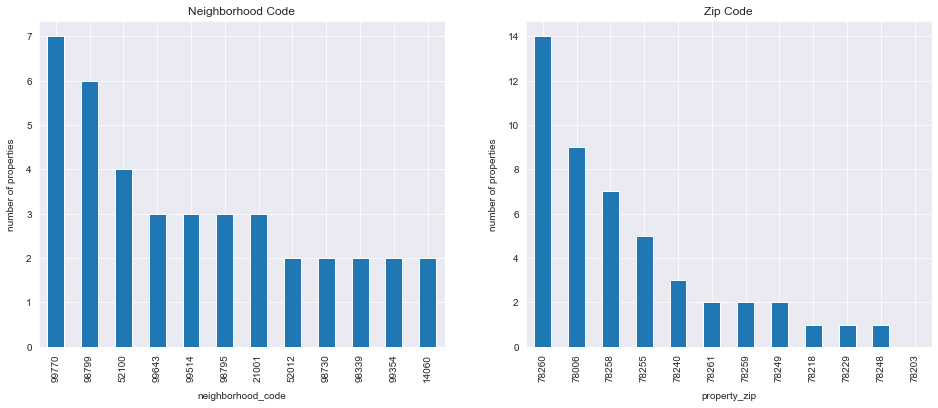

In [153]:
crim_sub_df = prop_df[prop_df.crim_prop==1]
groups = ['neighborhood_code','property_zip']
titles = ['Neighborhood Code','Zip Code']

plots = len(groups)
fig, axes = plt.subplots((int(plots/2)),2,figsize=[16,6])

for ax, var, title in zip(axes.flat,groups,titles):
    crim_sub_df[str(var)].value_counts()[:12].plot(kind='bar',ax=ax,title=title)
    ax.set_xlabel(var,labelpad=10)
    ax.set_ylabel("number of properties",labelpad=10)
plt.show()

These two figures do further indicate there is a geographic component to the properties labeled as criminally-linked.

### Distribution of Last Deed Transfer Date 

How many of the properties in the 2019 dataset have changed hands since 1990?

8448 properties have had their deed transferred since 1990.


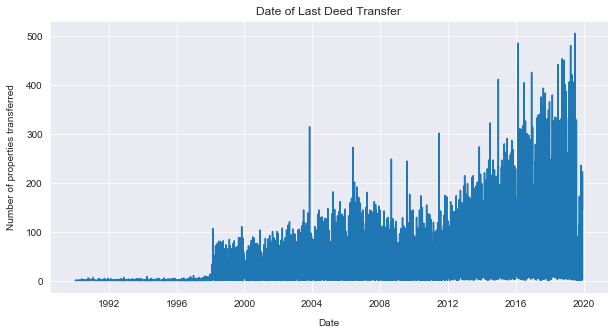

In [161]:
num_transfer = prop_df.deed_dt.value_counts().sort_index().loc['1990-01-01':,].count()
print("{} properties have had their deed transferred since 1990.".format(num_transfer))

# What is the distribution of the deed_dt in the dataset Bexar County
plt.figure(figsize=(10,5))
plt.plot(prop_df.deed_dt.value_counts().sort_index().loc['1990-01-01':,])
plt.title("Date of Last Deed Transfer")
plt.ylabel('Number of properties transferred', labelpad=10)
plt.xlabel('Date', labelpad=10)
plt.show()

### Different Ownership Types Across Labels

In [162]:
# Are these properties owned by companies or people?
print(prop_df[prop_df.crim_prop==1]['owner_legal_person'].value_counts())
print(prop_df[prop_df.crim_prop==1]['owner_likely_company'].value_counts())

1    39
0     9
Name: owner_legal_person, dtype: int64
1    41
0     7
Name: owner_likely_company, dtype: int64


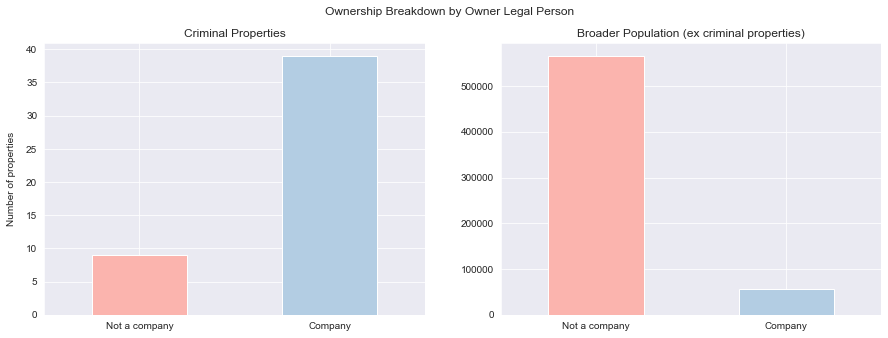

In [187]:
# Plot the breakdown between the two
fig, axes = plt.subplots(1,2,figsize=[15,5])
fig.suptitle("Ownership Breakdown by Owner Legal Person")
color=plt.cm.Pastel1(np.arange(len(crim_company_counts)))

# Criminially-associated properties
crim_company_counts = crim_sub_df.owner_legal_person.value_counts().sort_index()
crim_company_counts.index = ['Not a company','Company']
crim_company_counts.plot.bar(
    rot=0,ax=axes[0],
    title="Criminal Properties",
    color=color
)
axes[0].set_ylabel('Number of properties',labelpad=10)

# Broader population (ex criminal properties)
pop_company_counts = prop_df[prop_df.crim_prop!=1].owner_legal_person.value_counts().sort_index()
pop_company_counts.index = ['Not a company','Company']
pop_company_counts.plot.bar(
    rot=0,ax=axes[1],
    title="Broader Population (ex criminal properties)",
    color=color
)

plt.show()

In [190]:
crim_likely_co = crim_sub_df.owner_likely_company.value_counts().sort_index()
crim_likely_co.index = ['Not a company','Company']
crim_likely_co

Not a company     7
Company          41
Name: owner_likely_company, dtype: int64

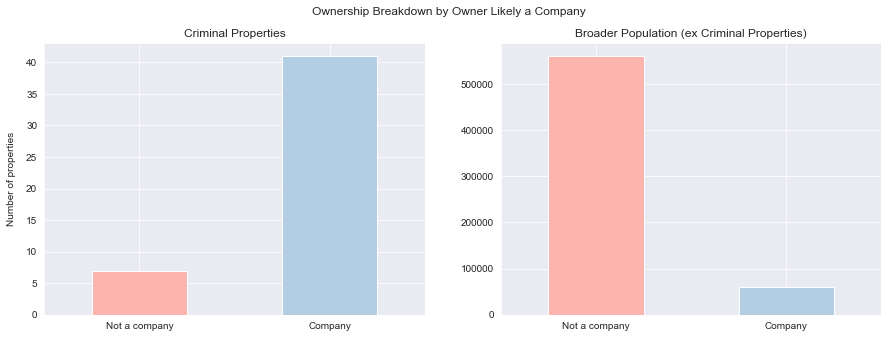

In [193]:
fig, axes = plt.subplots(1,2,figsize=[15,5])
fig.suptitle("Ownership Breakdown by Owner Likely a Company")
crim_likely_co = crim_sub_df.owner_likely_company.value_counts().sort_index()
crim_likely_co.index = ['Not a company','Company']
crim_likely_co.plot.bar(
    rot=0,
    ax=axes[0],
    title="Criminal Properties",
    color=color
    
)
axes[0].set_ylabel('Number of properties',labelpad=10)

pop_likely_co = prop_df[prop_df.crim_prop!=1].owner_likely_company.value_counts().sort_index()
pop_likely_co.index = ['Not a company','Company']
pop_likely_co.plot.bar(
    rot=0,
    ax=axes[1],
    title="Broader Population (ex Criminal Properties)",
    color=color
)
pop_likely_co.index = ['Not a company','Company']
plt.show()

The broader population of residential properties are far more often owned by a natural person than a company. The opposite is true for those properties labeled as criminally-linked, matching a common typology for money-laundering in real property.

### Price PSF Across Different Ownership Types

In [ ]:
print("Price psf for properties where the owner is a legal person:")
print(prop_df.groupby('owner_legal_person')['price_psf'].agg(['describe']),'\n')

print("Price psf for properties where the owner is likely a company:")
print(prop_df.groupby('owner_likely_company')['price_psf'].agg(['describe']),'\n')

print("Price psf for properties where the owner is a trust:")
print(prop_df.groupby('owner_is_trust')['price_psf'].agg(['describe']))

groups = ['owner_legal_person','owner_likely_company','owner_is_trust']
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=[15,8])

for ax, var in zip(axes.flat,groups):
    prop_df[['price_psf',var]].boxplot(by=[var], ax=ax)

fig.suptitle("Price PSF Breakdown by Ownership Type")
plt.show()

For cases where the owner is coded as either a legal person, "likely a company," or trust, the mean price per square foot seems higher. However, the median price per square foot for the first two is lower than the median price where the owner is not a legal person or likely a company. This makes sense given the outliers visible in the boxplots.

In [ ]:
print("Price psf for properties where the two measurable GTO requirements are met:")
print(prop_df.groupby('two_gto_reqs')['price_psf'].agg(['describe']),'\n')

print("Price psf for properties where the owner is foreign-based:")
print(prop_df.groupby('foreign_based_owner')['price_psf'].agg(['describe']),'\n')

groups = ['two_gto_reqs','foreign_based_owner']
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=[15,8])

for ax, var in zip(axes.flat,groups):
    prop_df[['price_psf',var]].boxplot(by=[var], ax=ax)

fig.suptitle("Price PSF Breakdown")
plt.show()

It seems the combination of the property being valued at more than $300,000 and owned by a company equals a higher average price per square foot. The owner being based outside of the United States, does not appear to be associated with that much of a difference in price per square foot.

In [ ]:
fig, axes = plt.subplots(1,2,figsize=[15,5])
fig.suptitle("Price PSF")
prop_df[prop_df['two_gto_reqs']==1].price_psf.dropna().plot(kind='hist',ax=axes[0],bins=50,
                                                            log=True,title='Property meets Two GTO Reqs',color='red')
prop_df[prop_df['two_gto_reqs']!=1].price_psf.dropna().plot(kind='hist',ax=axes[1],bins=50,
                                                            log=True,title='Property doesn\'t meet Two GTO Reqs',color='blue')
plt.show()

Similar to the above, there seems to be a wider range of prices per square foot when the property meets two of the FinCen GTO requirements.

In [ ]:
fig, axes = plt.subplots(1,2,figsize=[15,5])
fig.suptitle("Price PSF")
prop_df[prop_df['foreign_based_owner']==1].price_psf.dropna().plot(kind='hist',ax=axes[0],bins=50,
                                                                   log=True,title='Owner is based outside the US',
                                                                   color='red')
prop_df[prop_df['foreign_based_owner']!=1].price_psf.dropna().plot(kind='hist',ax=axes[1],bins=50,
                                                                   log=True,title='Owner is based in the US',
                                                                   color='blue')
plt.show()

### Just-Established Owner and Owner Owns Multiple Properties
Does a just-established owner pay a higher price psf? What about an owner that owns multiple properties?

In [ ]:
print("Price psf for properties where the owner is just-established:")
print(prop_df.groupby('just_established_owner')['price_psf'].agg(['describe']),'\n')

print("Price psf for properties where the owner owns multiple properties:")
print(prop_df.groupby('owner_owns_multiple')['price_psf'].agg(['describe']),'\n')

groups = ['just_established_owner','owner_owns_multiple']
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=[15,8])

for ax, var in zip(axes.flat,groups):
    prop_df[['price_psf',var]].boxplot(by=[var], ax=ax)
plt.suptitle('Price PSF')
plt.show()

While there are some outliers making the average higher, the median price per square for properties owned by companies established in the last 365 days is actually lower. It is a similar case for when the property owner owns multiple properties.

### Visualizing YoY Price Fluctuations

How do the fluctuations in price year-over-year differ between positively-labeled properties and the broader population?

In [ ]:
prop_melt = pd.melt(prop_df[prop_df.crim_prop!=1][['yoy_diff_2019','yoy_diff_2018','yoy_diff_2017','yoy_diff_2016']],var_name='year',value_name='yoy_diff').dropna()
crim_sub_melt = pd.melt(prop_df[prop_df.crim_prop==1][['yoy_diff_2019','yoy_diff_2018','yoy_diff_2017','yoy_diff_2016']],var_name='year',value_name='yoy_diff').dropna()

fig, axes = plt.subplots(1,2,figsize=[15,5])
sns.barplot(x='year',y='yoy_diff',data=prop_melt,palette='pastel',ax=axes[0]).set_title('YoY Differences (Broad Pop)')
sns.barplot(x='year',y='yoy_diff',data=crim_sub_melt,palette='pastel',ax=axes[1]).set_title('YoY Differences (Criminal Properties)')
plt.show()

### Missing Values

Identifying how many missing values there are per variable will allow meto to narrow down the list of variables that will be used in modeling.

In [ ]:
# How many missing values
ax = prop_df.isnull().sum().sort_values().plot.barh(figsize = [12,12])
ax.set_title('Number of Missing Data Points by Variable')
plt.show()

This is generally in line with what I was expecting. Most of the missing variables are from the companies data merge. Aside from owner_zip_code, the others will be dropped as features.

In [ ]:
print('Price PSF nulls:')
print(prop_df.price_psf.isnull().sum(),'\n')
print('YoY Diff 2016 nulls:')
print(prop_df.yoy_diff_2016.isnull().sum(),'\n')

### Correlation Matrix

In [ ]:
# Setting the number of acceptable NaN values to 70,000 to be sure to include Price PSF as a feature
nan_limit = 70000
check_nan = prop_df.isnull().sum()

variables_list = check_nan[check_nan<nan_limit].index
variables_list = variables_list[variables_list.isin(prop_df.columns[prop_df.dtypes!='object'])]
variables_list = variables_list.drop(['prop_id','py_owner_id','py_addr_zip_cass','prop_val_yr','appraised_val',
                                     'Prior_Mkt_Val','bexar_2015_market_value','bexar_2016_market_value', 
                                      'bexar_2017_market_value','bexar_2018_market_value'])

print(variables_list)

In [ ]:
prop_df[variables_list].head(10)

In [ ]:
# Pull out variables and plot correlation matrix
sub_df = prop_df[variables_list]
print(len(variables_list))
sub_df.corr()

In [ ]:
plt.figure(figsize=(14,14))
sns.heatmap(sub_df.corr(),vmax=1,square=True)
plt.show()

Observations:
- High correlation amongst the "confidential flag" variables, which makes sense. 
- Negative correlation between the year the property was built and price per square foot; this also makes intuitive sense. 
- It is interesting that there is also a negative correlation between the owner likely being a company and the year the property was built as well as the owner owning multiple properties.
- Does not seem to be much correlation between the criminal property label and the other variables